# Notæ 7

# Incidencia de cotas primales y duales en la resolución de PLE

## Introducción

En esta nota vamos a repasar algunas técnicas para mejorar la optimización de la resolución de Programas
Lineales Enteros. Como sabemos, la optimización alcanza su fin cuando convergen la cota primal (aquella que
surge de la obtención de una solución entera factible del problema) y la cota dual (aquella dada por la peor
relajación entre los actuales nodos hoja evaluados del árbol B&B).

Por ejemplo, si en nuestro problema, resulta sencillo elevar la cota dual pero es difícil encontrar soluciones factibles,
una posible solución es barrer el árbol B&B enfatizando en la búsqueda de soluciones, es decir que su recorrido sea de tipo
primero-profundo. Así CPLEX va a priorizar profundizar en el árbol hasta encontrar soluciones enteras. El caso inverso es
querer enfatizar en la mejora de la cota dual, aquí CPLEX va a priorizar evaluar aquellos nodos cuya relajación lineal sea
la que está imponiendo la actual cota dual. Su recorrido se asemeja a una búsqueda a lo ancho.
La estrategia actual de CPLEX es balancear ambos aspectos, pero puede parametrizarse.

Pero además de la forma de explorar el árbol B&B, tenemos herramientas para atacar ambas cotas, que son:
- Heurísticas primales: consisten en aprovechar la solución fraccionaria de un nodo para fabricar una solución entera; esto
evita que CPLEX tenga que profundizar en el árbol para alcanzarla, dejando nodos abiertos innecesariamente.
- Rutinas de separación de desigualdades válidas: consisten en aprovechar la solución fraccionaria de un nodo para generar
desigualdades que lo corten y así elevar el resultado de la relajación lineal, el que impactará en la cota dual.

Vamos a seguir como caso de estudio al Problema de Coloreo de Grafos clásico (PCG) formulado mediante variables de asignación vértice-color. En esta formulación, las variables $x_{vk}$ son binarias y valen 1 cuando al vértice $v$ se le asigna el color $k$.
Las variables $w_k$ también son binarias y valen 1 cuando el color $k$ es utilizado por algún vértice.

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{COL} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in V} x_{vk} \geq w_k & \forall~k \in \mathcal C. \tag{3} \\ 
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

No obstante, las restricciones $(3)$ pueden omitirse ya que se satisfacen naturalmente en la solución óptima (probar en Actividad 1).

### Repaso: Resolverlo con CPLEX

In [1]:
from docplex.mp.model import Model
import networkx as nx

In [2]:
def max_grado(G):
    grados = [G.degree(v) for v in G]
    return max(grados)

def construir_modelo_col(G, C):
    """Construye un modelo de PLE para el PCV."""
    
    modelo = Model(name='col') # Inicializamos el modelo 
    
    # Variables
    X = [[modelo.binary_var(name='x_' + str(v) + '_' + str(k)) for k in C] for v in G]
    W = [modelo.binary_var(name='w_' + str(k)) for k in C]
    
    # Funcion objetivo
    modelo.minimize(modelo.sum(W[k] for k in C))
    
    # Restricciones (1)
    for v in G:
        modelo.add_constraint(modelo.sum(X[v][k] for k in C) == 1)
    # Restricciones (2)
    for u, v in G.edges:
        for k in C:
            modelo.add_constraint(X[u][k] + X[v][k] <= W[k])    
    
    return modelo

def resolver(modelo, archivo=True):
    
    # Resolvemos el modelo
    sol = modelo.solve(log_output=archivo)
 
    # Retornamos la solucion
    return sol

Ejemplo de ejecución.

In [3]:
G = nx.wheel_graph(5)
C = range(0,max_grado(G) + 1)
modelo = construir_modelo_col(G, C)
sol = resolver(modelo)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 20 rows and 0 columns.
MIP Presolve modified 20 coefficients.
Reduced MIP has 25 rows, 30 columns, and 105 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.07 ticks)
Found incumbent of value 5.000000 after 0.04 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 25 rows, 30 columns, and 105 nonzeros.
Reduced MIP has 30 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.12 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Clique table members: 25.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (0.05 ticks)

        Nodes                                         

Imprimamos la solución:

In [4]:
sol.display()

solution for: col
objective: 3
status: OPTIMAL_SOLUTION(2)
x_0_3 = 1
x_1_4 = 1
x_2_1 = 1
x_3_4 = 1
x_4_1 = 1
w_1 = 1
w_3 = 1
w_4 = 1


### Actividad 1

- Explique qué tipo de soluciones enteras elimina la restricción $(COL.3)$. De un ejemplo, tomando como grafo la rueda de grado 5.
- Genere un grafo aleatorio de 20, otro de 25 y otro de 30 vértices, con 50% de densidad de aristas. Utilice la formulación anterior para resolverlo. Luego repítalo, pero añadiendo la restricción $(COL.3)$. ¿Ve alguna mejora en el tiempo de resolución?  

## Cotas duales

Vamos a comenzar proponiendo potenciales desigualdades válidas para el problema que permitan ajustar su relajación
lineal. Para eso, observemos cómo resolver la relajación lineal de una formulación PLE, lo cual es muy sencillo:

In [5]:
from docplex.mp.relax_linear import LinearRelaxer

def relajacion_lineal(modelo):
    return LinearRelaxer.make_relaxed_model(modelo)

Ejemplo de ejecución.

In [6]:
relajacion = relajacion_lineal(modelo)
sol = resolver(relajacion)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 45 rows, 30 columns, and 145 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 68 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixing 9 variables.
        8 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 3, exchanged 6.
  Primal:  Fixing 4 variables.
        3 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  2.22044605e-16  Objective  2.00000000e+00
  Primal:  Pushed 3, exchanged 1.


Imprimos la solución:

In [7]:
sol.display()

solution for: lp_col
objective: 2.000
status: OPTIMAL_SOLUTION(2)
x_0_0 = 0.500
x_0_3 = 0.500
x_1_0 = 0.500
x_1_3 = 0.500
x_2_0 = 0.500
x_2_3 = 0.500
x_3_0 = 0.500
x_3_3 = 0.500
x_4_0 = 0.500
x_4_3 = 0.500
w_0 = 1.000
w_3 = 1.000


### Reforzando relajaciones lineales

Vamos a estar interesados en hallar desigualdades válidas que violen una solución fraccionaria como la mostrada más arriba, pero a la vez que, al incorporar esta desigualdad en la formulación, logre elevar el valor objetivo lo más posible. Un proxy para maximizar este aumento es la violación: es decir, considerar una desigualdad $a.x \leq b$ que maximice $a.x - b$ sujeto a las restricciones de $(COL)$.  

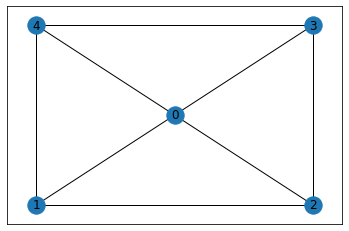

In [8]:
# Rueda de grado 4
nx.draw_networkx(G, pos={0: (1,1), 1: (0,0), 2: (2,0), 3: (2,2), 4: (0,2)})

Los vértices 0, 1 y 2 forman una clique. Por lo tanto, para todo color $k$, todo coloreo verifica que a lo sumo un vértice de {0,1,2} se pinta con $k$. Es decir, tenemos las siguientes desigualdades válidas:

$$ x_{0k} + x_{1k} + x_{2k} \leq w_k,~~~~~~ \forall~ k \in \mathcal C $$

Es crucial notar que, por el contrario, no toda solución fraccionaria (i.e. solución factible de la relajación lineal) las verifica. Por ejemplo, la solución fraccionaria encontrada anteriormente la viola para $k=0$, pues $$x_{00}+x_{10}+x_{20} = 1,5 \not\leq 1 = w_0.$$ 
Verifiquemos esta última cuenta:

In [9]:
print("Lado izquierdo: ", sol.get_value("x_0_0") + sol.get_value("x_1_0") + sol.get_value("x_2_0"))
print("Lado derecho: ", sol.get_value("w_0"))

Lado izquierdo:  1.5
Lado derecho:  1.0


¡Esta desigualdad válida que encontramos podemos usarla para ajustar nuestro poliedro! Es decir, agregando esta restricción a la formulación cortamos la solución fraccionaria que encontramos anteriormente. ¡Hagámoslo!

Primero recuperemos las variables $x$ del modelo.

In [10]:
def recuperar_variables(G, C, modelo):
    X = [[modelo.get_var_by_name("x_" + str(v) + "_" + str(k)) for k in C] for v in G]
    W = [modelo.get_var_by_name("w_" + str(k)) for k in C]
    return X, W

Agregamos la restricción al modelo.

In [11]:
modelo_ajustado = construir_modelo_col(G, C)
X, W = recuperar_variables(G, C, modelo_ajustado)
modelo_ajustado.add_constraint(X[0][0] + X[1][0] + X[2][0] <= W[0])

docplex.mp.LinearConstraint[](x_0_0+x_1_0+x_2_0,LE,w_0)

Resolvemos la relajación lineal.

In [12]:
relajacion_ajustada = relajacion_lineal(modelo_ajustado)
sol = resolver(relajacion_ajustada)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 46 rows, 30 columns, and 149 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 54 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000

Dual crossover.
  Dual:  Fixing 4 variables.
        3 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 1, exchanged 3.
  Primal:  Fixing 3 variables.
        2 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Primal:  Pushed 2, exchanged 1.


Veamos la solución.

In [13]:
sol.display()

solution for: lp_col
objective: 2.000
status: OPTIMAL_SOLUTION(2)
x_0_1 = 0.500
x_0_3 = 0.500
x_1_1 = 0.500
x_1_3 = 0.500
x_2_1 = 0.500
x_2_3 = 0.500
x_3_1 = 0.500
x_3_3 = 0.500
x_4_1 = 0.500
x_4_3 = 0.500
w_1 = 1.000
w_3 = 1.000


Obviamente, obtuvimos una solución distinta, sin embargo no cambió su valor objetivo. ¿Qué pasó? Lo que pasó es que nos dio una solución simétrica, apagó el color 0 y encendió el 1. Ok, entonces agreguemos estas desigualdades válidas para todos los colores.

In [14]:
modelo_ajustado = construir_modelo_col(G, C)
X, W = recuperar_variables(G, C, modelo_ajustado)
for k in C:
    modelo_ajustado.add_constraint(X[0][k] + X[1][k] + X[2][k] <= W[k])
relajacion_ajustada = relajacion_lineal(modelo_ajustado)
sol = resolver(relajacion_ajustada)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 50 rows, 30 columns, and 165 nonzeros.
Presolve time = 0.01 sec. (0.04 ticks)
Symmetry aggregator did 67 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 20 variables.
       19 PMoves:  Infeasibility  0.00000000e+00  Objective  3.00000000e+00
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  3.00000000e+00
  Primal:  Pushed 8, exchanged 12.


Veamos la solución.

In [15]:
sol.display()

solution for: lp_col
objective: 3.000
status: OPTIMAL_SOLUTION(2)
x_0_0 = 0.250
x_0_2 = 0.125
x_0_3 = 0.250
x_0_4 = 0.375
x_1_0 = 0.250
x_1_1 = 0.250
x_1_3 = 0.250
x_1_4 = 0.250
x_2_0 = 0.500
x_2_2 = 0.125
x_2_4 = 0.375
x_3_0 = 0.250
x_3_2 = 0.125
x_3_4 = 0.625
x_4_0 = 0.750
x_4_3 = 0.250
w_0 = 1.000
w_1 = 0.250
w_2 = 0.250
w_3 = 0.500
w_4 = 1.000


¡Éxito! No solo cortamos la solución fraccionaria anterior (y sus soluciones simétricas), sino que además pudimos elevar el valor óptimo de la relajación lineal, pasó de 2 a 3.

Aunque el trabajo que hicimos fue específico al grafo rueda $W_5$, este tipo de desigualdades válidas se pueden aplicar a cualquier grafo, y a cualquier clique.

### Restricciones clique

<b>Proposición.</b> Considerar el modelo COL para una instancia del PCG formada por un grafo $G=(V,E)$ y un conjunto de colores $\mathcal C$. Para toda clique $Q \subset V$ y color $k \in \mathcal C$, la siguiente restricción es una desigualdad válida
$$\sum_{v \in Q}x_{vk} \leq w_k,$$
y se conoce como <b>restricción clique</b>.

<b>Observación 1.</b> Las restricciones $(COL.2)$ son restricciones clique asociadas a cliques de cardinal 2 (los extremos de la arista). 

<b>Observación 2.</b> En particular, siendos dos cliques $Q' \subset Q$, la restricción clique asociada a $Q$ domina a la asociada a $Q'$, pues $$\sum_{v \in Q'}x_{vk} \leq \sum_{v \in Q}x_{vk} \leq w_k.$$ Por lo tanto, basta con considerar cliques maximales. Llamaremos $\mathcal Q$ al conjunto de cliques maximales del grafo.

Existen dos formas de manejar desigualdades válidas:

1. Agregarlas como restricciones de la formulación.

2. Agregarlas bajo demanda como planos de corte.

### Desigualdades válidas en la formulación

Comencemos agregando a la formulación COL todas las restricciones cliques asociadas a $\mathcal Q$. Es decir, ahora nuestra formulación de PLE es la siguiente.

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{CLI} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in Q} x_{vk} \leq w_k & \forall~Q \in \mathcal Q,~  k \in \mathcal C. \tag{3} \\
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

<b>Observación.</b> Las restricciones $(2)$ quedan implicadas por las $(3)$, luego podemos sacarlas de la formulación sin perder soluciones factibles. Para no complicar las cosas, las dejaremos y confiaremos en el poder de CPLEX para detectar y eliminar restricciones redundantes.

In [16]:
def construir_modelo_cli(G, C):
    modelo = construir_modelo_col(G, C)
    modelo.name = "cli"
    X, W = recuperar_variables(G, C, modelo)
    for Q in nx.find_cliques(G):
        for k in C:
            modelo.add_constraint(modelo.sum(X[v][k] for v in Q) <= W[k])
    return modelo

Trabajaremos un grafo aleatorio con $n=...$ y $p=...$.

In [17]:
G = nx.erdos_renyi_graph(18, 0.5, 0)
C = range(max_grado(G)+1)
modelo_col = construir_modelo_col(G, C)
modelo_cli = construir_modelo_cli(G, C)

Resolvamos la relajación lineal del modelo COL.

In [18]:
relajacion_col = relajacion_lineal(modelo_col)
resolver(relajacion_col)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
Reduced LP has 668 rows, 190 columns, and 2130 nonzeros.
Presolve time = 0.00 sec. (0.57 ticks)
Symmetry aggregator did 756 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixing 12 variables.
       11 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  2.00000000e+00
  Dual:  Pushed 0, exchanged 12.
  Primal:  Fixing 9 variables.
        8 PMoves:  Infeasibility  8.32667268e-17  Objective  2.00000000e+00
        0 PMoves:  Infeasibility  3.05311332e-16  Objective  2.00000000e+00
  Primal:  Pushed 8, exchanged 1.


docplex.mp.solution.SolveSolution(obj=2,values={x_0_0:0.5,x_0_5:0.5,x_1_..

Resolvamos la relajación lineal del modelo CLI.

In [19]:
relajacion_cli = relajacion_lineal(modelo_cli)
resolver(relajacion_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 30 rows and 0 columns.
Reduced LP has 968 rows, 190 columns, and 3470 nonzeros.
Presolve time = 0.01 sec. (0.88 ticks)
Symmetry aggregator did 1026 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.000000

Dual crossover.
  Dual:  Fixing 1 variable.
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  4.00000000e+00
  Dual:  Pushed 0, exchanged 1.
  Primal:  Fixing 45 variables.
       44 PMoves:  Infeasibility  3.35842465e-15  Objective  4.00000000e+00
        0 PMoves:  Infeasibility  1.65978342e-14  Objective  4.00000000e+00
  Primal:  Pushed 16, exchanged 29.


docplex.mp.solution.SolveSolution(obj=4,values={x_0_1:0.333333,x_0_4:0.3..

Veamos un resumen de los resultados:

In [20]:
def imprimir_resumen(modelo):
    print(modelo.name, ":")
    print("\tNúmero de restricciones: ", modelo.number_of_constraints)
    print("\tTiempo: ", modelo.solve_details.time, " s")
    print("\tValor objetivo: ", modelo.objective_value)
    print("\tNúmero de nodos: ", modelo.solve_details.nb_nodes_processed)
    
imprimir_resumen(relajacion_col)
imprimir_resumen(relajacion_cli)

lp_col :
	Número de restricciones:  668
	Tiempo:  0.02591395378112793  s
	Valor objetivo:  2.0
	Número de nodos:  0
lp_cli :
	Número de restricciones:  998
	Tiempo:  0.030215024948120117  s
	Valor objetivo:  4.0
	Número de nodos:  0


La relajación lineal de COL tiene menos restricciones y su resolución es más rápida, pero la cota inferior que aporta es bastante débil. Por el contrario, la relajación lineal de CLI presenta una marcada mejora en el valor objetivo, aunque posee más restricciones y su resolución demora más tiempo.

Con este análisis solo estamos evaluando lo que sucede en el nodo raíz del árbol de branch-and-cut. ¿Qué pasará cuando consideremos el árbol completo? La intuición nos dice que comenzar con una relajación más ajustada hará que CPLEX pueda podar nodos con mayor rapidez y cerrar el gap anticipadamente.

Como ya hemos mencionado, CPLEX es muy potente y es capaz de ajustar por su cuenta las formulaciones de PLE. Para no generar resultados sesgados por estos mecanismos adicionales, decidimos apagarlos durante los próximos experimentos.

In [21]:
def apagar_artilleria(modelo):
    modelo.parameters.preprocessing.presolve = 0
    modelo.parameters.mip.cuts.cliques = -1
    modelo.parameters.preprocessing.symmetry = 0
    #TODO: SEGUIR APAGANDO COSAS

Ahora vamos a resolver los modelos, empezando por COL. Las siguientes celdas pueden demorar en ejecutarse. Momento para armar unos &#129481;  &#129481;.

In [22]:
apagar_artilleria(modelo_col)
resolver(modelo_col)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Cuts_Cliques                        -1
CPXPARAM_Preprocessing_Symmetry                  0
Found incumbent of value 10.000000 after 0.05 sec. (3.08 ticks)
Clique table members: 668.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (3.94 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.0000        0.0000           100.00%
*     0+    0                            6.0000        0.0000           100.00%
      0     0        2.0000    36        6.0000        2.0000      179   66.67%
      0     0        2.0000    36        6.0000      Cuts: 33      235   66.

docplex.mp.solution.SolveSolution(obj=5,values={x_0_8:1,x_1_8:1,x_2_8:1,..

Ahora resolvamos CLI.

In [23]:
apagar_artilleria(modelo_cli)
resolver(modelo_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Cuts_Cliques                        -1
CPXPARAM_Preprocessing_Symmetry                  0
Found incumbent of value 10.000000 after 0.01 sec. (3.03 ticks)
Clique table members: 998.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.07 sec. (42.10 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           10.0000        0.0000           100.00%
*     0+    0                            6.0000        0.0000           100.00%
*     0+    0                            5.0000        0.0000           100.00%
      0     0        4.0000    42        5.0000        4.0000     1336   20

docplex.mp.solution.SolveSolution(obj=5,values={x_0_5:1,x_1_0:1,x_2_5:1,..

Comparemos los resultados.

In [24]:
imprimir_resumen(modelo_col)
imprimir_resumen(modelo_cli)

col :
	Número de restricciones:  668
	Tiempo:  3.729548215866089  s
	Valor objetivo:  5.0
	Número de nodos:  4452
cli :
	Número de restricciones:  998
	Tiempo:  0.5357630252838135  s
	Valor objetivo:  5.0
	Número de nodos:  0


El siguiente análisis dependerá de los números que cada uno/a haya obtenido en su computadora (espero que las tendencias sean las mismas, de lo contrario probar con una semilla diferente al generar el grafo $G$). 

En mi caso, ....

A pesar de que en cada nodo del árbol de branch-and-cut las relajaciones de CLI son más pesadas (pues tienen más restricciones y el simplex requiere de más iteraciones), las cotas duales son más ajustadas y se pueden podar mayor cantidad de nodos, lo que compensa el tiempo extra que se necesita para resolver cada nodo.

In [25]:
print("Promedio de tiempo por nodo: ", 
      modelo_col.solve_details.time / modelo_col.solve_details.nb_nodes_processed, "s (COL), ", 
      modelo_cli.solve_details.time / modelo_cli.solve_details.nb_nodes_processed, "s (CLI)")

ZeroDivisionError: float division by zero

### Actividad 2

Supongamos que, en la formulación original, reemplazamos las restricciones $(COL.2)$ por las siguientes, denominadas "de vecindad":
$$ f(v) x_{vk} + \sum_{u \in N(v)} x_{uk} \leq f(v),~~ \forall~v \in V,~k \in \mathcal C $$
donde $f(v)$ es el grado del vértice $v$ (por ahora 😉).
Esta desigualdad es válida porque resulta de sumar todas las $(COL.2)$ que comparten un mismo vértice, en este caso $v$.
Siendo que estas restricciones son en total $|V|.|\mathcal C|$ mientras que las $(COL.2)$ contabilizan $|E|.|\mathcal C|$, ¿será que esta disminución compensa la calidad de la relajación lineal?
- Genere algunas instancias aleatorias, a su criterio.
- Compare el valor óptima de la relajación lineal de ambas formulaciones en dichas instancias.
- Realice un experimento donde compara el tiempo de resolución de ambas ejecuciones, ¿quién se comporta mejor? Y si ahora incorporamos las desigualdades cliques, ¿se mantiene la tendencia? ¿alguna formulación resulta mejor que la otra para distintas densidades del grafo?
- Elija una instancia donde difieren significativamente los resultados para cada formulación, ¿y si ahora apaga la artillería de CPLEX? ¿se mantiene la tendencia? "+1" si encuentran un caso en que sí 🙂 
- (Opcional) Si $f(v)$ fuese menor, la desigualdad ajustaría más. Piense qué valor podría asignarle a $f(v)$ para lograrlo, en el caso de la rueda de grado $n$, para cualquier $n \geq 4$ (tenemos dos casos: el "interesante" cuando $v$ es el vértice central, y el otro cuando $v$ es el pendiente). Ahora intente generalizar ese concepto.

### Cubrimiento de aristas con subgrafos completos

Por supuesto, en instancias grandes no es esperable que se puedan agregar a la formulación todas las desigualdades válidas asociadas a cliques máximales (pues su número crece exponencialmente con el tamaño del grafo). Una alternativa es no agregarlas a todas, sino solo algunas de ellas. Por ejemplo, pada cada arista del grafo, podemos maximalizar de forma greedy la clique formada por sus extremos. Es decir, generar un cubrimiento de las aristas del grafo con subgrafos completos. Como resultado, obtenemos la siguiente formulación, que es más ajustada que COL, pero menos ajustada que CLI. 

\begin{align*}
\text{Minimizar:} & \sum_{k \in \mathcal C}w_k \tag{CUB} \\
\text{Sujeto a:} & \sum_{k \in \mathcal C} x_{vk} = 1 & \forall~v \in V. \tag{1}\\
& x_{vk} + x_{uk} \leq w_k & \forall~vu \in E,~  k \in \mathcal C. \tag{2} \\
& \sum_{v \in Q} x_{vk} \leq w_k & \forall~Q \in \mathcal Q',~  k \in \mathcal C. \tag{3} \\
& w_k \in \{0,1\} & \forall~k \in \mathcal C.\\
& x_{vk} \in \{0,1\} & \forall~v \in V,~k \in \mathcal C.
\end{align*}

In [26]:
## Función del notebook 2

def maximalizar_clique(G, C):
    M = list(C) # Copiar la lista C
    for v in G:
        if v in M:
            continue
        ok = True
        for u in M:
            if not G.has_edge(u,v):
                ok = False
        if ok:
            M.append(v)
    return M

In [27]:
def cubrir(G):
    cubrimiento = []
    esta_cubierta = {e: False for e in G.edges()}
    for e in G.edges():
        if esta_cubierta[e]:
            continue
        H = nx.edge_subgraph(G, [e2 for e2 in esta_cubierta if not esta_cubierta[e2]])
        clique = maximalizar_clique(H , e)
        clique = maximalizar_clique(G, clique)
        for i, u in enumerate(clique):
            for j, v in enumerate(clique):
                if i < j:
                    esta_cubierta[(u,v)] = True
        cubrimiento.append(clique)
    return cubrimiento

In [28]:
def construir_modelo_cub(G, C):
    modelo = construir_modelo_col(G, C)
    modelo.name = "cub"
    X, W = recuperar_variables(G, C, modelo)
    for Q in cubrir(G):
        for k in C:
            modelo.add_constraint(modelo.sum(X[v][k] for v in Q) <= W[k])
    return modelo

Hagamos algunos experimentos para evaluar la performance de ambas formulaciones (CLI y CUB). Tomaremos un grafo un poco más grande...

In [29]:
G = nx.erdos_renyi_graph(35, 0.5, 0)
C = range(max_grado(G)+1)
modelo_cli = construir_modelo_cli(G, C)
modelo_cub = construir_modelo_cub(G, C)

Primero analicemos las relajaciones lineales.

In [30]:
relajacion_cli = relajacion_lineal(modelo_cli)
resolver(relajacion_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 4 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 3 threads...
Tried aggregator 1 time.
Reduced LP has 13835 rows, 828 columns, and 59869 nonzeros.
Presolve time = 0.04 sec. (12.97 ticks)
Symmetry aggregator did 13992 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             4.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 748 variables.
      747 PMoves:  Infeasibility  0.00000000e+00  Objective  7.00000000e+00
      515 PMoves:  Infeasibility  2.95596880e-15  Objective  7.00000000e+00
      291 PMoves:  Infeasibility  1.81243909e-14  Objective  7.00000000e+00
      110 PMoves:  Infeasibility  3.85802501e-15  Objective  7.00000000e+00
        0 PMoves:  Infeasibility  2.45108225e-11  Object

docplex.mp.solution.SolveSolution(obj=7,values={x_0_0:0.12381,x_0_2:0.02..

In [31]:
relajacion_cub = relajacion_lineal(modelo_cub)
resolver(relajacion_cub)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 4 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 3 threads...
Tried aggregator 1 time.
LP Presolve eliminated 230 rows and 0 columns.
Reduced LP has 8959 rows, 828 columns, and 32982 nonzeros.
Presolve time = 0.03 sec. (8.15 ticks)
Symmetry aggregator did 9328 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 770 variables.
      769 PMoves:  Infeasibility  0.00000000e+00  Objective  7.00000000e+00
      463 PMoves:  Infeasibility  0.00000000e+00  Objective  7.00000000e+00
      246 PMoves:  Infeasibility  1.44328993e-15  Objective  7.00000000e+00
       98 PMoves:  Infeasibility  3.60822483e-16  Objective  7.00000000e+00
        0 PM

docplex.mp.solution.SolveSolution(obj=7,values={x_0_0:0.103817,x_0_1:0.0..

Comparemos los resultados.

In [32]:
imprimir_resumen(relajacion_cli)
imprimir_resumen(relajacion_cub)

lp_cli :
	Número de restricciones:  13835
	Tiempo:  0.3304011821746826  s
	Valor objetivo:  7.0
	Número de nodos:  0
lp_cub :
	Número de restricciones:  9189
	Tiempo:  0.2617530822753906  s
	Valor objetivo:  7.0
	Número de nodos:  0


Ahora si, veamos la performance del branch-and-cut.

In [33]:
apagar_artilleria(modelo_cli)
resolver(modelo_cli)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Cuts_Cliques                        -1
CPXPARAM_Preprocessing_Symmetry                  0
Found incumbent of value 23.000000 after 0.10 sec. (64.37 ticks)
Clique table members: 13835.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.58 sec. (200.52 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.0000        0.0000           100.00%
*     0+    0                           22.0000        0.0000           100.00%
*     0+    0                           21.0000        0.0000           100.00%
*     0+    0                           10.0000        0.0000          

docplex.mp.solution.SolveSolution(obj=7,values={x_0_3:1,x_1_14:1,x_2_14:..

In [34]:
apagar_artilleria(modelo_cub)
resolver(modelo_cub)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Cuts_Cliques                        -1
CPXPARAM_Preprocessing_Symmetry                  0
Found incumbent of value 23.000000 after 0.10 sec. (42.23 ticks)
Clique table members: 9189.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.37 sec. (166.51 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.0000        0.0000           100.00%
*     0+    0                           19.0000        0.0000           100.00%
*     0+    0                           10.0000        0.0000           100.00%
*     0+    0                            8.0000        0.0000           

docplex.mp.solution.SolveSolution(obj=7,values={x_0_11:1,x_1_8:1,x_2_8:1..

Veamos un resumen de los resultados.

In [35]:
imprimir_resumen(relajacion_cli)
imprimir_resumen(relajacion_cub)

lp_cli :
	Número de restricciones:  13835
	Tiempo:  0.3304011821746826  s
	Valor objetivo:  7.0
	Número de nodos:  0
lp_cub :
	Número de restricciones:  9189
	Tiempo:  0.2617530822753906  s
	Valor objetivo:  7.0
	Número de nodos:  0


### Desigualdades válidas bajo demanda

In [36]:
def construir_modelo_pool(G, C):
    modelo = construir_modelo_col(G, C)
    X, W = recuperar_variables(G, C, modelo)
    for Q in nx.find_cliques(G):
        for k in C:
            modelo.add_user_cut_constraint(modelo.sum(X[v][k] for v in Q) <= W[k])
    return modelo

In [37]:
modelo_pool = construir_modelo_pool(G, C)
modelo_pool.parameters.preprocessing.presolve = 0
resolver(modelo_pool)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 23.000000 after 0.04 sec. (18.94 ticks)
Clique table members: 6889.
Problem contains 6946 user cuts.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.20 sec. (87.05 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                           23.0000        0.0000           100.00%
*     0+    0                           22.0000        0.0000           100.00%
*     0+    0                           21.0000        0.0000           100.00%
*     0+    0                           10.0000        0.0000           100.00%
*     0+    0                            8.0000        0.0000  

docplex.mp.solution.SolveSolution(obj=7,values={x_0_2:1,x_1_3:1,x_2_3:1,..

### Rankear experimentalmente desigualdades válidas

Tenemos una desigualdad válida y queremos ver si corta soluciones fraccionarias. Por ejemplo, podría pasar que esté implicada, es decir, que se obtenga a partir de desigualdades del modelo. Maximizar el lado izquierdo de la desigualdad.

In [38]:
relajacion2 = relajacion_lineal(modelo)
x_0_0 = relajacion2.get_var_by_name("x_0_0")
x_1_0 = relajacion2.get_var_by_name("x_1_0")
x_2_0 = relajacion2.get_var_by_name("x_2_0")
relajacion2.maximize(x_0_0 + x_1_0 + x_2_0)
sol = resolver(relajacion2)
print(relajacion2.objective_value)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 0 rows and 5 columns.
Reduced LP has 45 rows, 25 columns, and 105 nonzeros.
Presolve time = 0.00 sec. (0.04 ticks)
Symmetry aggregator did 51 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             2.000000

Dual crossover.
  Dual:  Fixed no variables.
  Primal:  Fixing 15 variables.
       14 PMoves:  Infeasibility  0.00000000e+00  Objective  1.50000000e+00
        0 PMoves:  Infeasibility  0.00000000e+00  Objective  1.50000000e+00
  Primal:  Pushed 15, exchanged 0.
1.5


In [39]:
relajacion2.find_matching_vars("x_")

[docplex.mp.Var(type=C,name='x_0_0',ub=1),
 docplex.mp.Var(type=C,name='x_0_1',ub=1),
 docplex.mp.Var(type=C,name='x_0_2',ub=1),
 docplex.mp.Var(type=C,name='x_0_3',ub=1),
 docplex.mp.Var(type=C,name='x_0_4',ub=1),
 docplex.mp.Var(type=C,name='x_1_0',ub=1),
 docplex.mp.Var(type=C,name='x_1_1',ub=1),
 docplex.mp.Var(type=C,name='x_1_2',ub=1),
 docplex.mp.Var(type=C,name='x_1_3',ub=1),
 docplex.mp.Var(type=C,name='x_1_4',ub=1),
 docplex.mp.Var(type=C,name='x_2_0',ub=1),
 docplex.mp.Var(type=C,name='x_2_1',ub=1),
 docplex.mp.Var(type=C,name='x_2_2',ub=1),
 docplex.mp.Var(type=C,name='x_2_3',ub=1),
 docplex.mp.Var(type=C,name='x_2_4',ub=1),
 docplex.mp.Var(type=C,name='x_3_0',ub=1),
 docplex.mp.Var(type=C,name='x_3_1',ub=1),
 docplex.mp.Var(type=C,name='x_3_2',ub=1),
 docplex.mp.Var(type=C,name='x_3_3',ub=1),
 docplex.mp.Var(type=C,name='x_3_4',ub=1),
 docplex.mp.Var(type=C,name='x_4_0',ub=1),
 docplex.mp.Var(type=C,name='x_4_1',ub=1),
 docplex.mp.Var(type=C,name='x_4_2',ub=1),
 docplex.mp

### Actividad 3

- TODO

## Eliminación de soluciones simétricas

Otra forma de reducir el tiempo de optimización es reducir el espacio de búsqueda, durante la exploración de nodos del árbol B&B.
Decimos que un conjunto de soluciones $s_1$, $s_2$, ..., $s_n$ son simétricas si tienen el mismo valor objetivo. Observemos que podemos eliminar $s_2$, ..., $s_n$ sin afectar el resultado de la optimización. En el caso del problema de coloreo, esto equivale a eliminar soluciones con misma cantidad de colores.

Para eliminarlas, incorporamos nuevas restricciones a la formulación. Por ejemplo, en COL habíamos incorporado $(COL.3)$ para eliminar ciertas soluciones innecesarias. 

Ahora vamos a considerar distintas familias de desigualdades que eliminan soluciones simétricas, propuestas por I.$~$Méndez-Díaz y P.$~$Zavala. Supongamos que los colores están enumerados $\mathcal{C}=1,\ldots,c$:
- Orden en la cantidad de colores: Claramente una solución que utilice los colores de un subconjunto de tamaño $k$  de $\mathcal{C}$ usa la misma cantidad de colores que otra a la que se le asignan colores de $1,\ldots,k$ (por ejemplo, para una solución que utilice los colores $3,5,8$ existe otra que utiliza $1,2,3$). Podemos eliminar estas soluciones adicionales agregando:
$$w_k \geq w_{k+1},~~ \forall~ k = 1,\ldots,c-1~~~~~~(S1)$$
- Orden en los cardinales de los colores: Observemos que, para una solución que utiliza los colores $1,\ldots,k$, existen otras $k!-1$ soluciones simétricas en donde se hizo una permutación de sus colores. Podemos eliminar parcialmente estas soluciones si imponemos que los primeros colores tengan mayor cardinal que los últimos. Es decir, si $V_i$ representa a aquellos vértices pintados de $i$, podemos restringirnos a soluciones donde $|V_1| \geq |V_2| \geq ... \geq |V_k|$ con:
$$\sum_{v \in V} x_{vk} \geq \sum_{v \in V} x_{vk+1},~~ \forall~ k = 1,\ldots,c-1~~~~~~(S2)$$
- Eliminación de indistinguibles I: Teniendo en cuenta una enumeración de los vértices ($v_1$, $v_2$, ...) podemos, sin perder generalidad, imponer que el primer vértice sea coloreado con el primer color. Luego $v_2$ puede, o bien utilizar el mismo color, o bien uno nuevo, por lo que le permitimos colorearse con colores 1 o 2. En otras palabras, $v_1$ no se puede colorear con $\{2,\ldots,c\}$, $v_2$ no lo puede hacer con $\{3,\ldots,c\}$, etc. Siguiendo esta lógica proponemos:
$$x_{v_i k} = 0,~~ \forall~ k=i+1,\ldots,c,~ \forall~i=1,\ldots,c-1~~~~~~(S3)$$
Estas restricciones no son compatibles con $(S2)$.
- Eliminación de indistinguibles II: Dejamos al lector entender el significado de estas desigualdades que, junto con $(S1)$ y $(S3)$, eliminan todas las $k!-1$ soluciones simétricas:
$$\sum_{j=k-1}^{i-1} x_{u_jk-1} \geq x_{v_ik}~~ \forall~ i=k+1,\ldots,c,~ \forall~k=2,\ldots,c-1~~~~~~(S4)$$


### Actividad 4

- Incorpore las restricciones que eliminan simetrías a la formulación. Llamémoslas:
  - $COL_1$: Formulación original
  - $COL_2$: $COL_1$ + $(S1)$ (Orden en la cantidad de colores)
  - $COL_3$: $COL_2$ + $(S2)$ (Orden en los cardinales de los colores)
  - $COL_4$: $COL_2$ + $(S3)$ (Eliminación de indistinguibles I)
  - $COL_5$: $COL_4$ + $(S4)$ (Eliminación de indistinguibles II)
- Para grafos con densidades de 10%, 50% y 90%, ¿hasta qué cantidad de vértices es posible resolver una instancia con las formulaciones dadas (por densidad) para un tiempo límite de 5 minutos? Concluya cuáles de las restricciones que eliminan simetrías conviene considerar.